# Маркетинговая аналитика Яндекс.Афиши.

Необходимо помочь маркетологам Яндекс.Афиши снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:

* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

**Описание данных**

У нас есть три датасета.

Файл *visits_log.csv* хранит лог сервера с информацией о посещениях сайта, *orders_log.csv* — информацию о заказах, а *costs.csv* — информацию о расходах на маркетинг.

Структура visits_log.csv

- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.


Структура orders_log.csv

- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.


Структура costs.csv

- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

## Изучение общей информации и предобработка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import scipy.stats as sps
import numpy as np


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


pd.options.display.max_columns = None

In [2]:
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
custom_date_parser1 = lambda x: datetime.strptime(x, "%Y-%m-%d")
visits=pd.read_csv('visits_log.csv', parse_dates=['End Ts', 'Start Ts'], date_parser=custom_date_parser)
orders=pd.read_csv('orders_log.csv', parse_dates=['Buy Ts'], date_parser=custom_date_parser)
costs=pd.read_csv('costs.csv', parse_dates=['dt'], date_parser=custom_date_parser1)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
visits.head()
visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  object        
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders.head()
orders.info()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [6]:
costs.head()
costs.info()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Изучили общую информация от таблицах.

    1. При загрузке таблиц, сразу перевели столбцы с датой, в тип данных datetime.
    2. Нужно все названия столбцов привести к одному регистру, и изменить названия столбцов без нижнего подчеркивания, в столбцы с подчеркиванием.

## Предобработка данных

In [7]:
visits.columns = visits.columns.str.replace(' ', '_')
visits.columns = visits.columns.str.lower()

orders.columns = orders.columns.str.replace(' ', '_')
orders.columns = orders.columns.str.lower()
#привели названия столбцов к одному регистру, и также изменили названия столбцов.

In [8]:
visits['end_ts'].max()
visits['start_ts'].max()
visits['end_ts'].min()
visits['start_ts'].min()
orders['buy_ts'].min()
orders['buy_ts'].max()
costs['dt'].min()
costs['dt'].max()
#посмотрим какие периоды дат содержатся в таблицах.

Timestamp('2018-06-01 01:26:00')

Timestamp('2018-05-31 23:59:00')

Timestamp('2017-06-01 00:02:00')

Timestamp('2017-06-01 00:01:00')

Timestamp('2017-06-01 00:10:00')

Timestamp('2018-06-01 00:02:00')

Timestamp('2017-06-01 00:00:00')

Timestamp('2018-05-31 00:00:00')

В таблицах должны быть данные с июня 2017 по конец мая 2018 года. Сохраним таблицы visits и orders с нужными нам датами.

In [9]:
visits.isnull().sum()
orders.isnull().sum()
costs.isnull().sum()
visits.duplicated().sum()
orders.duplicated().sum()
costs.duplicated().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

buy_ts     0
revenue    0
uid        0
dtype: int64

source_id    0
dt           0
costs        0
dtype: int64

0

0

0

## Рассчитайте метрики и постройте графики

### Продуктовые метрики

#### Рассчет DAU, WAU и MAU.

In [10]:
visits['year']=visits['start_ts'].dt.year
visits['month']=visits['start_ts'].dt.month
visits['week']=visits['start_ts'].dt.week
visits['date']=visits['start_ts'].dt.date
#Для расчета пользовательской активности выделим отдельные столбцы с годом, месяцем, неделей и полной датой.

In [11]:
dau_total=visits.groupby(['date']).agg({'uid':'nunique'})
wau_total=visits.groupby(['year', 'week']).agg({'uid':'nunique'})
mau_total=visits.groupby(['year', 'month']).agg({'uid':'nunique'})
dau_total.head()
mau_total.head()
wau_total.head()

,uid
date,
2017-06-01,605
2017-06-02,608
2017-06-03,445
2017-06-04,476
2017-06-05,820


uid
year month       
2017 6      13259
     7      14183
     8      11631
     9      18975
     10     29692

uid
year week      
2017 22    2021
     23    4129
     24    2812
     25    2878
     26    3064

<AxesSubplot:title={'center':'Количество посещений уникальных пользователей за день'}, xlabel='date'>

Text(0, 0.5, 'Количество посещений')

Text(0.5, 0, 'Дата')

,uid
count,364.000000
mean,907.991758
std,370.513838
min,1.000000
25%,594.000000
50%,921.000000
75%,1173.000000
max,3319.000000


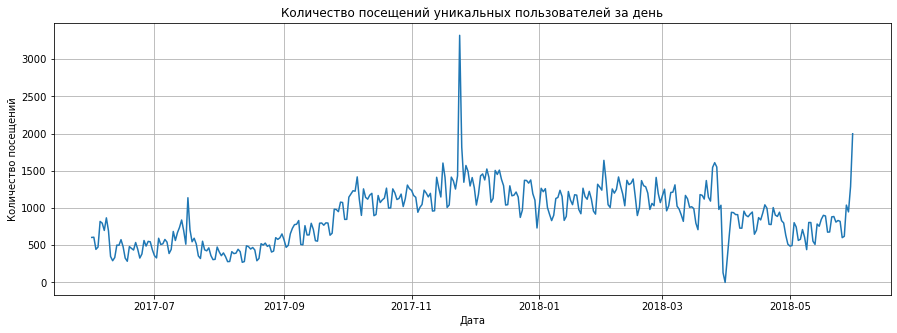

In [12]:
dau_total.plot(y='uid', figsize=(15, 5), grid=True, 
               title='Количество посещений уникальных пользователей за день', legend=False)
plt.ylabel('Количество посещений')
plt.xlabel('Дата')
dau_total.describe()

В среднем сайт посещают 907 уникальных пользователей в день. В конце декабря заметен резкий рост посесщений сайта, возможно это связано с предстоящими праздниками.

<AxesSubplot:title={'center':'Количество посещений уникальных пользователей за неделю'}, xlabel='year,week'>

Text(0, 0.5, 'Количество посещений')

Text(0.5, 0, 'Неделя')

,uid
count,53.000000
mean,5716.245283
std,2049.898027
min,2021.000000
25%,4128.000000
50%,5740.000000
75%,7401.000000
max,10586.000000


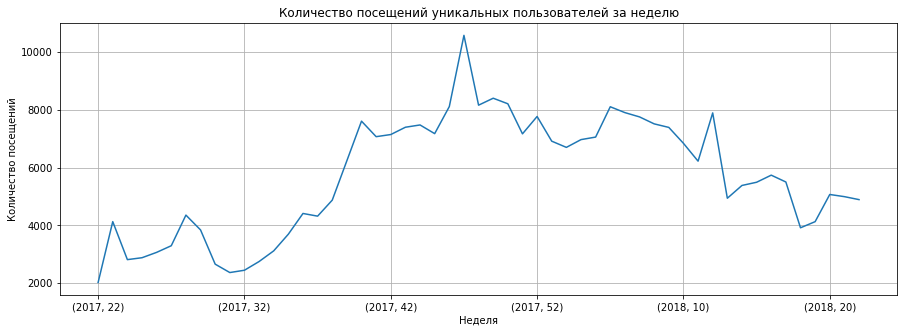

In [13]:
wau_total.plot(y='uid', figsize=(15, 5), grid=True, 
               title='Количество посещений уникальных пользователей за неделю', legend=False)
plt.ylabel('Количество посещений')
plt.xlabel('Неделя')
wau_total.describe()

В среднем в неделю сайт посещают 5716 уникальных пользователей.

<AxesSubplot:title={'center':'Количество посещений уникальных пользователей за месяц'}, xlabel='year,month'>

Text(0, 0.5, 'Количество посещений')

Text(0.5, 0, 'Месяц')

,uid
count,12.000000
mean,23228.416667
std,7546.380462
min,11631.000000
25%,17777.000000
50%,24240.500000
75%,28984.750000
max,32797.000000


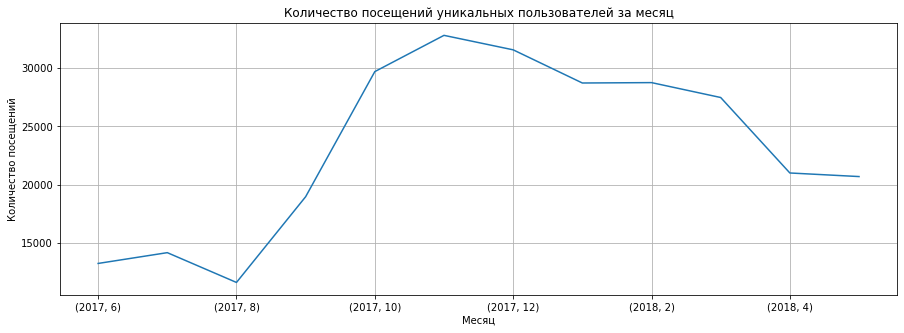

In [14]:
mau_total.plot(y='uid', figsize=(15, 5), grid=True, 
               title='Количество посещений уникальных пользователей за месяц', legend=False)
plt.ylabel('Количество посещений')
plt.xlabel('Месяц')
mau_total.describe()

В среднем сайт посещают 23 227 уникальных пользователей в месяц. По графику видно, что в ноябре сайт посещает максимальное количество пользователей.

Изучив данные пользовательской активности узнали, что:

    1. Среднее значение DAU = 907;
    2. Среднее значение WAU = 5 716; 
    3. Среднее значение MAU = 23 227.

#### Сколько раз за день пользователи в среднем заходят на сайт. 

In [15]:
dau_mean=visits.groupby(['date']).agg({'uid':'count'})

<AxesSubplot:title={'center':'Количество посещений пользователей за день'}, xlabel='date'>

Text(0, 0.5, 'Количество посещений')

Text(0.5, 0, 'Дата')

,uid
count,364.000000
mean,987.362637
std,418.994796
min,1.000000
25%,635.500000
50%,1003.000000
75%,1280.000000
max,4042.000000


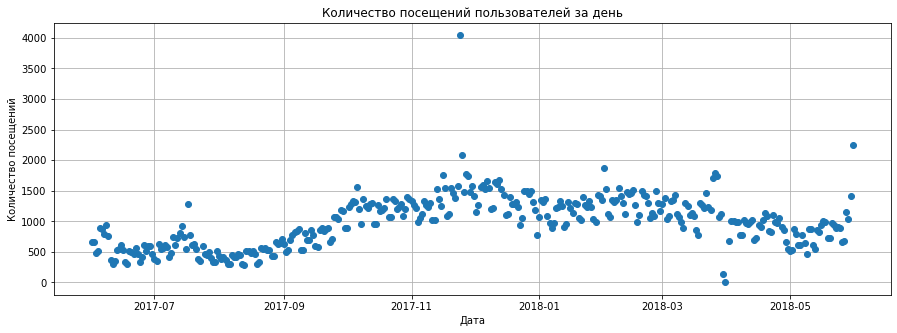

In [16]:
dau_mean.plot(y='uid', style='o', figsize=(15, 5), grid=True, 
              title='Количество посещений пользователей за день', legend=False)
plt.ylabel('Количество посещений')
plt.xlabel('Дата')
dau_mean.describe()

В среднем пользователи заходят на сайт 987 раз в день, а уникальных посещений 907. Из этого можно сделать вывод, что люди пользуются сайтом не больше 1 раза в день. 

#### Сколько времени пользователи проводят на сайте. 

In [17]:
visits['time']=(visits['end_ts']-visits['start_ts']).dt.seconds

In [18]:
visits['time'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: time, dtype: float64

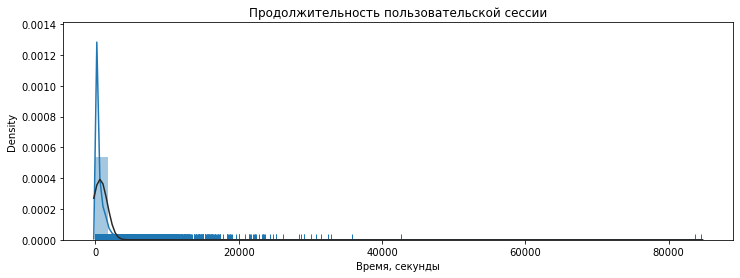

In [19]:
plt.figure(figsize=(12,4));
sns.distplot(visits['time'], rug=True, fit=sps.norm, bins=50);
plt.xlabel('Время, секунды');
plt.title('Продолжительность пользовательской сессии');

Построив график видим, что распределение далеко от нормального. Из-за этого продолжительность сессии стоит брать не среднюю, а моду. 

In [20]:
visits['time'].mode()

0    60
dtype: int64

Мода получилась слишком маленькой, возьмем за продолжительность сессии медианное значение оно равно 300 секундам.

####  Retention Rate.

In [21]:
#Возьмем дату, когда пользователь впервые совершил действие на Яндекс.Афише и объединим с таблицей visits.
first_activity_date=visits.groupby('uid')['start_ts'].min()
first_activity_date.name='first_activity_date'
visits_activity=visits.join(first_activity_date, on='uid')

#Добавим в датафрейм visits_activity столбцы с месяцем сессии и первым месяцем визита.
visits_activity['month_visit']=visits_activity['date'].values.astype('datetime64[M]')
visits_activity['first_month_visit']=visits_activity['first_activity_date'].values.astype('datetime64[M]')

#Посчитаем lifitime пользователей по когортам.
visits_activity['cohort_lifetime']=visits_activity['month_visit']-visits_activity['first_month_visit']
visits_activity['cohort_lifetime']=visits_activity['cohort_lifetime'] / np.timedelta64(1,'M')
visits_activity['cohort_lifetime']=round(visits_activity['cohort_lifetime']).astype('int')

#Сгруппировали данные по первому месяцу визита и по lifitime. Посчитаем количество уникальных пользователей
#на каждый месяц.
cohorts=visits_activity.groupby(['first_month_visit','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

#Найдем исходное количество пользователей в когорте, возьмем их число на нулевой месяц.
initial_users_count=cohorts[cohorts['cohort_lifetime']==0][['first_month_visit','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

#Объединим данные по когортам с исходным количеством пользователей в когорте. И рассчитаем retention rate.
cohorts = cohorts.merge(initial_users_count,on='first_month_visit') 
cohorts['retention']=cohorts['uid']/cohorts['cohort_users']

#Построим сводную таблицу и ниже тепловую карту.
retention_pivot=cohorts.pivot_table(
    index='first_month_visit',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)
retention_pivot

#Построим сводную таблицу, чтобы узнать средний Retention Rate на второй месяц «жизни» когорт.
retention_pivot2=cohorts.pivot_table(
    columns='cohort_lifetime',
    values='retention',
    aggfunc='mean',
)
retention_pivot2

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month_visit,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
retention,1.0,0.065167,0.046333,0.04276,0.040595,0.039444,0.036957,0.037509,0.035465,0.035159,0.034062,0.044951


<Figure size 936x648 with 0 Axes>

<AxesSubplot:xlabel='cohort_lifetime', ylabel='first_month_visit'>

Text(0.5, 1.0, 'Когорты: Retention')

Text(0.5, 57.5, '"Возраст" когорты')

Text(93.5, 0.5, 'Когорта')

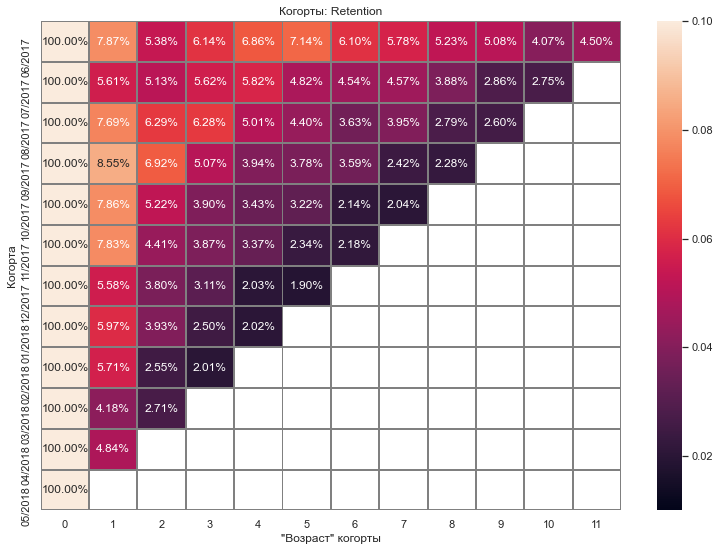

In [22]:
retention_pivot.index = retention_pivot.index.strftime("%m/%Y")
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
sns.heatmap(retention_pivot, vmin=0.01, vmax=0.1, annot=True, fmt='.2%', linewidths=1, linecolor='gray')
plt.title('Когорты: Retention')
plt.xlabel('"Возраст" когорты')
plt.ylabel('Когорта')

Коэффициент удержания очень низкий, также он убывает и внутри когорты, и от когорты к когорте.

Средний коэффициент удержания на 2 месяц "жизни" когорт равен 4.63%.

### Метрики электронной коммерции

#### Cколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 

In [23]:
#выделим из таблицы первый заказ пользователя
first_orders=orders.groupby('uid')['buy_ts'].min()
first_orders.name='first_orders'
#объединим таблицы
orders=orders.join(first_orders, on='uid')
#выделим из таблицы дату первой сессии
first_visits=visits.groupby('uid')['start_ts'].min()
first_visits.name='first_visits'

In [24]:
first_orders = pd.DataFrame(first_orders).reset_index()
first_visits = pd.DataFrame(first_visits).reset_index()

In [25]:
#объединим таблицы
first_orders=first_orders.merge(first_visits, on='uid')
#рассчитали количество дней от первой покупки до первого посещения.
first_orders['time']=(first_orders['first_orders']-first_orders['first_visits']).dt.days

In [26]:
first_orders['time'].describe()
first_orders['time'].mode()

count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: time, dtype: float64

0    0
dtype: int64

In [27]:
first_orders

,uid,first_orders,first_visits,time
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0
...,...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,95
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,0
36520,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,231
36521,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,103


In [28]:
first_orders=first_orders.query('time<30')

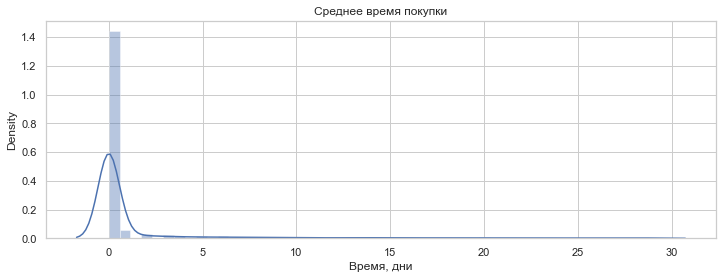

In [29]:
plt.figure(figsize=(12,4));
sns.distplot(first_orders['time'],hist=True);
plt.xlabel('Время, дни');
plt.title('Среднее время покупки');

Большая часть пользователей совершает покупку в тот же день, что и заходят на сайт.

#### Среднее количество покупок на одного покупателя за 6 месяцев. 

In [30]:
#добавили в таблицу месяу заказа и первый месяц заказа. 
orders['first_order_month']=orders['first_orders'].astype('datetime64[M]')
orders['order_month']=orders['buy_ts'].astype('datetime64[M]')
#отберем покупки сделанные за 6 месяцев
orders['time']=orders['order_month']-orders['first_order_month']
orders['time']=orders['time']/ np.timedelta64(1,'M')
orders['time']=orders['time'].round().astype('int')

six_month=orders[orders['time']<=5]
six_month

,buy_ts,revenue,uid,first_orders,first_order_month,order_month,time
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0


In [31]:
buy_mean=six_month.groupby('first_order_month').agg(
    {'uid':'nunique', 'buy_ts':'nunique', 'revenue':'sum'})
buy_mean['buy_per_user']=buy_mean['buy_ts']/buy_mean['uid']
buy_mean.head()

buy_mean['buy_per_user'].describe()

,uid,buy_ts,revenue,buy_per_user
first_order_month,,,,
2017-06-01,2023,3327,16912.45,1.644587
2017-07-01,1923,2553,14731.67,1.327613
2017-08-01,1370,1914,10104.93,1.397080
2017-09-01,2581,3505,31762.98,1.358001
2017-10-01,4340,5362,26734.21,1.235484


count    13.000000
mean      1.240803
std       0.174254
min       0.984270
25%       1.134758
50%       1.235484
75%       1.327613
max       1.644587
Name: buy_per_user, dtype: float64

<AxesSubplot:title={'center':'Среднее количество покупок на одного пользователя'}, xlabel='first_order_month'>

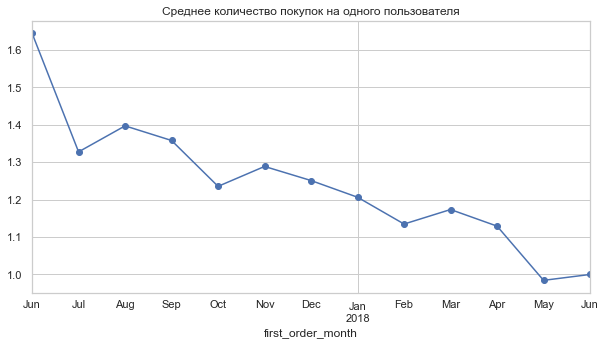

In [32]:
buy_mean['buy_per_user'].plot(figsize=(10,5), grid=True, style='o-', title='Среднее количество покупок на одного пользователя')

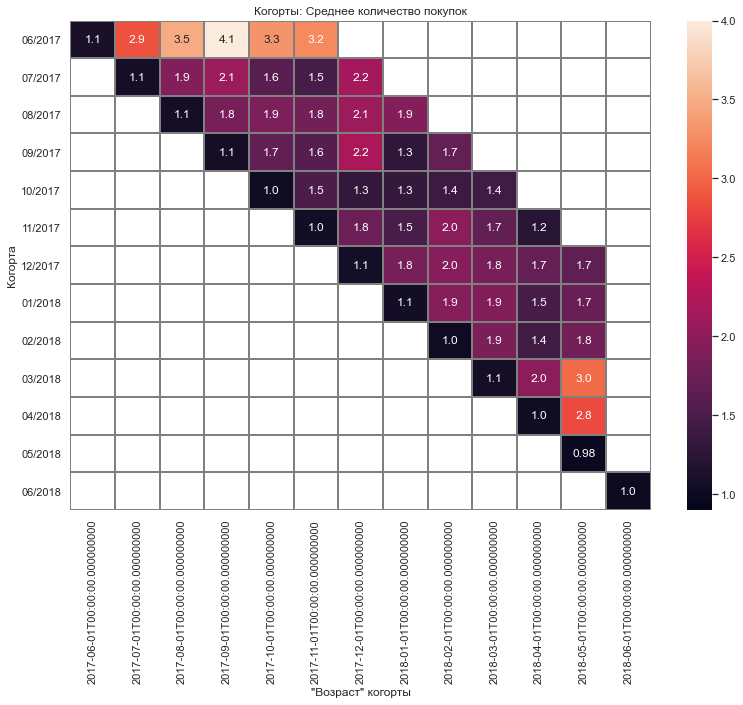

In [33]:
buy_mean_cohorts=six_month.groupby(['first_order_month', 'order_month']).agg(
    {'uid':'nunique', 'buy_ts':'nunique', 'revenue':'sum'})
buy_mean_cohorts['buy_per_user']=buy_mean_cohorts['buy_ts']/buy_mean_cohorts['uid']

buy_mean_cohorts=buy_mean_cohorts.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='buy_per_user',
    aggfunc='mean',
)

buy_mean_cohorts.index = buy_mean_cohorts.index.strftime("%m/%Y");
sns.set(style='whitegrid');
plt.figure(figsize=(13, 9));
sns.heatmap(buy_mean_cohorts, vmin=0.9, vmax=4, annot=True, fmt='.2', linewidths=1, linecolor='gray');
plt.title('Когорты: Среднее количество покупок');
plt.xlabel('"Возраст" когорты');
plt.ylabel('Когорта');

Среднее количество покупок на одного пользователя равно 1.26. Также количество покупок снижается от когорты к когороте. Лучший показатель среднего количества покупок у июньской когорты 2017 года, начиная со 2 месяца "жизни" когорты кол-во покупок составляет от 2 до 4.

#### Средний чек.

In [34]:
buy_mean2=orders.groupby('order_month').agg(
    {'uid':'nunique', 'buy_ts':'count', 'revenue':'sum'})
buy_mean2['mean']=buy_mean2['revenue']/buy_mean2['uid']
buy_mean2
buy_mean2['mean'].describe()

,uid,buy_ts,revenue,mean
order_month,,,,
2017-06-01,2023,2354,9557.49,4.724414
2017-07-01,1984,2363,12539.47,6.320297
2017-08-01,1472,1807,8758.78,5.950258
2017-09-01,2750,3387,18345.51,6.671095
2017-10-01,4675,5679,27987.70,5.986674
2017-11-01,4547,5659,27069.93,5.953360
2017-12-01,4942,6218,36388.60,7.363132
2018-01-01,3898,4721,19417.13,4.981306
2018-02-01,4258,5281,25560.54,6.002945


count    13.000000
mean      5.866514
std       1.014569
min       3.420000
25%       5.851010
50%       5.986674
75%       6.320297
max       7.363132
Name: mean, dtype: float64

<AxesSubplot:title={'center':'Средний чек на одного пользователя'}, xlabel='order_month'>

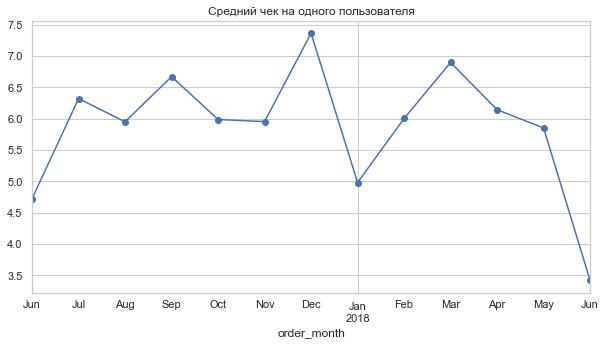

In [35]:
buy_mean2['mean'].plot(figsize=(10,5), grid=True, style='o-', title='Средний чек на одного пользователя')

Средний чек на одного покупателя равен 5.86.

По графику видно, что в декабре идет резкий взлет среднего чека, из-за ближайших праздников, а в январе резкий спад.

####  LTV на покупателя по когортам.

In [36]:
first_orders1=orders.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()

first_orders2=orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()

margin_rate = 1
#найдем валовую прибыль(в нашем случае она совпадает с суммой заказа, т.к. маржинальность равна 100%)
first_orders2['gp']=first_orders2['revenue']*margin_rate
#найдем "возраст" когорт
first_orders2['age'] = (
    first_orders2['order_month'] - first_orders2['first_order_month']
) / np.timedelta64(1, 'M')
first_orders2['age'] = first_orders2['age'].round().astype('int')

report2=pd.merge(first_orders2,first_orders1, on='first_order_month')

#рассчитаем LTV на покупателя по когортам. 
report2['ltv'] = report2['gp'] / report2['uid']
#выберем когорты "прожившие" более 6 месяцев.
report62=report2[report2['age']>=5]

output2=report62.pivot_table(
    index='first_order_month',
    columns='age',
    values='ltv',
    aggfunc='mean'
).cumsum(axis=1).round(2)
output2

age,5,6,7,8,9,10,11
first_order_month,,,,,,,
2017-06-01,0.74,1.69,2.27,2.82,3.43,4.00,4.25
2017-07-01,0.16,0.28,0.42,0.58,0.73,0.88,NaN
2017-08-01,0.28,0.49,0.90,1.19,1.38,NaN,NaN
2017-09-01,0.65,1.35,1.59,1.78,NaN,NaN,NaN
2017-10-01,0.12,0.21,0.32,NaN,NaN,NaN,NaN
2017-11-01,0.05,0.17,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.34,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#добавим месяц первой покупки для каждого пользователя
first_orders1=orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders1.columns = ['uid', 'first_order_month']

In [38]:
#сгруппируем по первой покупке и уникальным пользователям
cohort_sizes=(
    first_orders1.groupby('first_order_month')
    .agg({'uid':'nunique'})
    .reset_index())
cohort_sizes.columns=['first_order_month', 'n_buyers']

In [39]:
#сгруппируем по месяцу покупки, первому месяцу покупки и посичтаем сумму заказа.
cohorts_ltv=(
    orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue':'sum'})
    .reset_index())
#объединим таблицы
report=pd.merge(cohort_sizes,cohorts_ltv, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [40]:
margin_rate = 1
#найдем валовую прибыль(в нашем случае она совпадает с суммой заказа, т.к. маржинальность равна 100%)
report['gp']=report['revenue']*margin_rate
#найдем "возраст" когорт
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
#рассчитаем LTV на покупателя по когортам. 
report['ltv'] = report['gp'] / report['n_buyers']
#выберем когорты "прожившие" более 6 месяцев.
# report6=report[report['age']>=5]

output=report.pivot_table(
    index='first_order_month',
    columns='age',
    values='ltv',
    aggfunc='mean'
).cumsum(axis=1).round(2)
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 936x648 with 0 Axes>

Text(0.5, 1.0, 'Когорты: LTV')

<AxesSubplot:title={'center':'Когорты: LTV'}, xlabel='age', ylabel='first_order_month'>

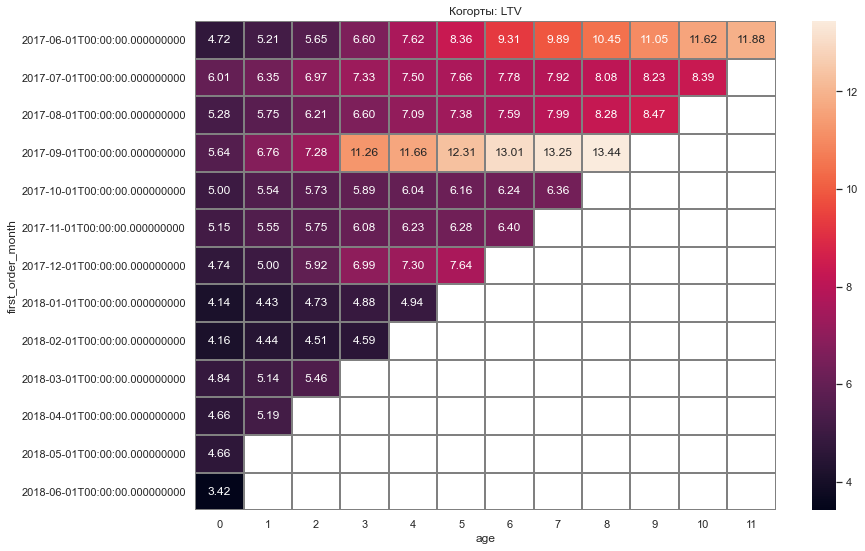

In [41]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
plt.title('Когорты: LTV')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

,first_order_month,ltv
0,2017-06-01,4.254652
1,2017-07-01,0.882127
2,2017-08-01,1.379401
3,2017-09-01,1.775831
4,2017-10-01,0.320647
5,2017-11-01,0.168807
6,2017-12-01,0.338047


<AxesSubplot:title={'center':'Итоговый LTV по когортам "проживших" не менее 6 месяцев'}, xlabel='first_order_month'>

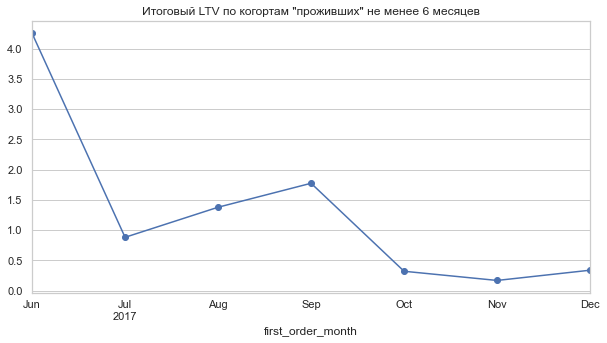

In [42]:
report6=report[report['age']>=5]
report6.groupby('first_order_month')['ltv'].sum().reset_index()
report6.groupby('first_order_month')['ltv'].sum().plot(figsize=(10,5), grid=True, style='o-',
                            title='Итоговый LTV по когортам "проживших" не менее 6 месяцев')

In [43]:
print('Cредний LTV по когортам за 6 месяцев:', (round(output[5].mean(),2)))

Cредний LTV по когортам за 6 месяцев: 7.97


Самый большой средний LTV мы видим в июньской - 4.25 и сентябрьской - 1.78 когорте

### Маркетинговые метрики

#### Общая сумма расходов на маркетинг. 

In [44]:
costs['dt'].describe()

count                    2542
unique                    364
top       2017-06-28 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [45]:
sum_costs=costs.pivot_table(index='source_id', values='costs', aggfunc='sum').sort_values(by='costs',ascending=False).reset_index()
sum_costs['costs'].sum()
sum_costs

329131.6199999999

,source_id,costs
0,3,141321.63
1,4,61073.60
2,5,51757.10
3,2,42806.04
4,1,20833.27
5,10,5822.49
6,9,5517.49


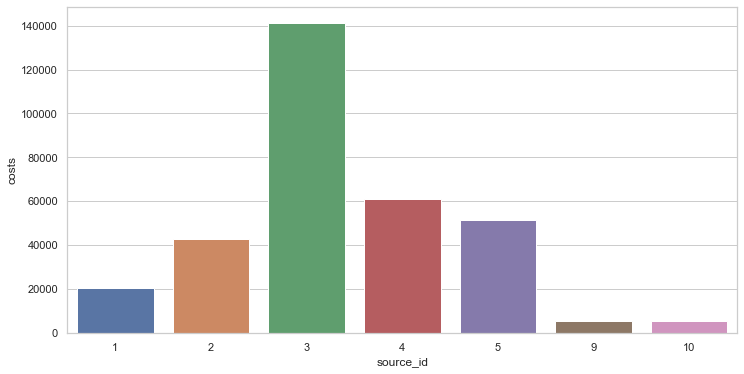

In [46]:
plt.figure(figsize=(12,6));
sns.barplot(data=sum_costs, x='source_id', y='costs');

In [47]:
costs['month']=costs['dt'].astype('datetime64[M]')

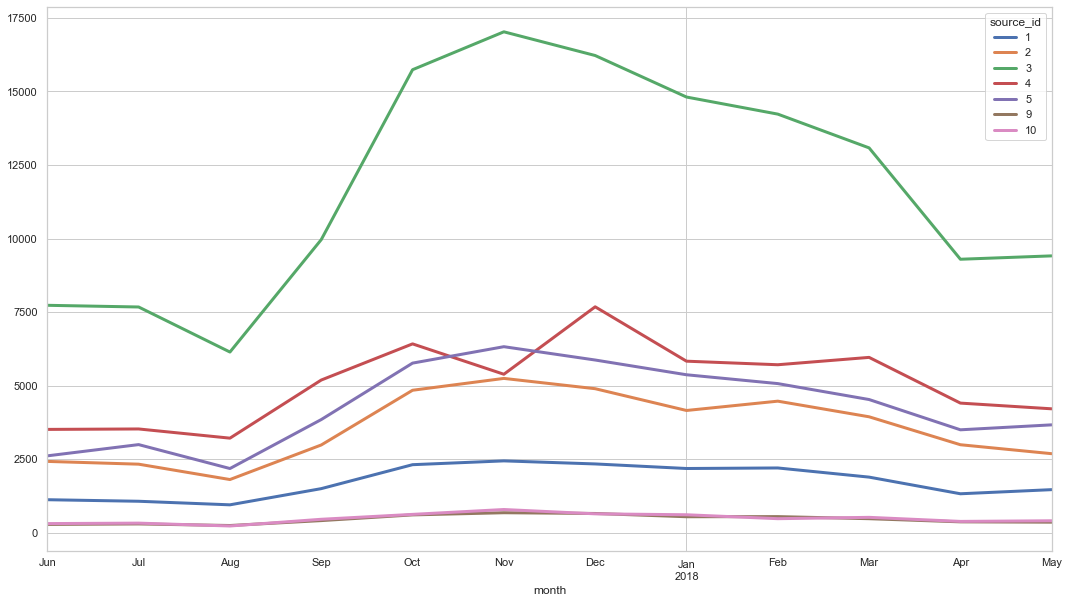

In [48]:
(costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')
                .plot(lw=3, figsize=(18,10), grid=False));
plt.grid();

Общая сумма расходов на маркетинг равна 329 131.62. Больше всего затрат ушло на источник №3. Меньше всего затрат на источник №9.

По графику plot видно, что по источнику №3 больше всего расходов было в декабре месяце. По источнику №4 видно резкое увеличение расходов в декабре. По остальным источникам самая большая сумма расходов была в ноябре.

Распределение трат по источникам:

| Источник     | Расходы |
| ------------- |:--------------------:| 
| 3           | 141321.63| 
| 4           | 61073.60| 
| 5          | 51757.10| 
| 2          | 42806.04|
|1	|20833.27|
|10|5822.49|
|9	|5517.49|


#### Средний CAC на одного покупателя для всего проекта.

In [49]:
#сгруппируем таблицу по месяцу проведения рекламной кампании и затратам на нее.
costs['month']=costs['dt'].astype('datetime64[M]') 
monthly_costs=costs.groupby('month')['costs'].sum()
monthly_costs

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

In [50]:
#объединили таблицы для расчета CAC на одного покупателя
report_new=pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac']=report_new['costs']/report_new['n_buyers']
report_new['cac'].mean()
report_new.head()

9.319905176921111

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,18015.0,8.905091


,first_order_month,cac
0,2017-06-01,8.905091
1,2017-07-01,9.485486
2,2017-08-01,10.796015
3,2017-09-01,9.441654
4,2017-10-01,8.369327
5,2017-11-01,9.288870
6,2017-12-01,8.741809
7,2018-01-01,9.937302
8,2018-02-01,8.962758
9,2018-03-01,8.608907


<AxesSubplot:title={'center':'Средний CAC на одного покупателя для всего проекта'}, xlabel='first_order_month'>

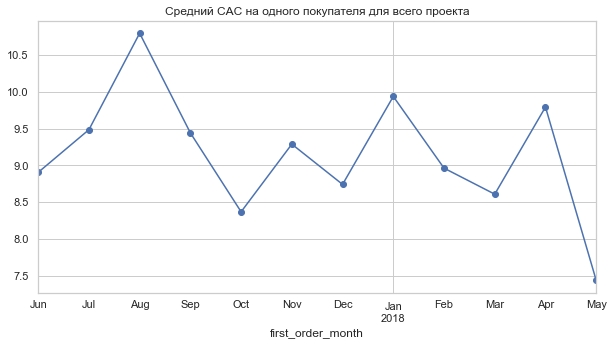

In [51]:
report_new.groupby('first_order_month')['cac'].mean().reset_index()
report_new.groupby('first_order_month')['cac'].mean().plot(figsize=(10,5), grid=True, style='o-',
                            title='Средний CAC на одного покупателя для всего проекта')

Средний CAC на одного покупателя для всего проекта равен 9.32. Больше всего денег на привлечение клиентов было вложено в августе.

#### Средний CAC для каждого источника трафика.

In [52]:
#сгруппировали таблицу по источнику и затратам.
costs_id=costs.groupby('source_id').agg({'costs':'sum'})

In [53]:
#сгруппируем таблицу по первому источнику посещения
visits['date']=visits['date'].astype('datetime64[M]') 
users=visits.sort_values(by=['uid', 'start_ts']).groupby('uid').agg({'source_id':'first', 'date':'first'})
#объединим таблицы
visits_orders=pd.merge(users, orders, on='uid')
#сгруппируем по месяцу, источнику и сумме расходов
costs_month=costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()
#сгруппируем по источнику, первому месяцу заказа, и посчитаем уникальных пользователей
visits_orders1=visits_orders.groupby(['source_id', 'first_order_month']).agg({'uid':'nunique'}).reset_index()
#объединим таблицы
cac=pd.merge(costs_month, visits_orders1, left_on=['source_id', 'month'], right_on=['source_id', 'first_order_month'])
#рассчитаем CAC для каждого источника
cac['cac']=cac['costs']/cac['uid']
cac

cac.pivot_table(index = 'first_order_month', columns = 'source_id', values = 'cac', aggfunc='mean')

,month,source_id,costs,first_order_month,uid,cac
0,2017-06-01,1,1125.61,2017-06-01,190,5.924263
1,2017-06-01,2,2427.38,2017-06-01,235,10.329277
2,2017-06-01,3,7731.65,2017-06-01,638,12.118574
3,2017-06-01,4,3514.80,2017-06-01,413,8.510412
4,2017-06-01,5,2616.12,2017-06-01,384,6.812813
...,...,...,...,...,...,...
79,2018-05-01,3,9411.42,2018-05-01,844,11.150972
80,2018-05-01,4,4214.21,2018-05-01,804,5.241555
81,2018-05-01,5,3669.56,2018-05-01,497,7.383421
82,2018-05-01,9,362.17,2018-05-01,60,6.036167


source_id,1,2,3,4,5,9,10
first_order_month,,,,,,,
2017-06-01,5.924263,10.329277,12.118574,8.510412,6.812813,4.194412,3.307579
2017-07-01,6.705500,11.216875,14.989004,6.827331,7.087801,5.818077,6.467059
2017-08-01,8.423097,14.723984,18.230089,9.518817,6.070222,4.080820,6.285676
2017-09-01,6.616784,13.509774,12.757426,8.800441,6.535042,4.777241,5.356628
2017-10-01,6.811029,12.234848,13.660799,5.478532,6.103069,4.836587,3.001148
2017-11-01,7.546790,13.185126,14.001102,4.578437,9.127475,4.711586,6.190313
2017-12-01,7.073112,12.855118,12.315505,5.577683,7.616757,5.437851,7.598353
2018-01-01,9.185630,14.238836,14.720457,5.651928,8.485814,6.839500,6.677717
2018-02-01,8.016291,15.270785,13.029817,5.164521,7.479808,6.565476,3.909593


<AxesSubplot:xlabel='first_order_month'>

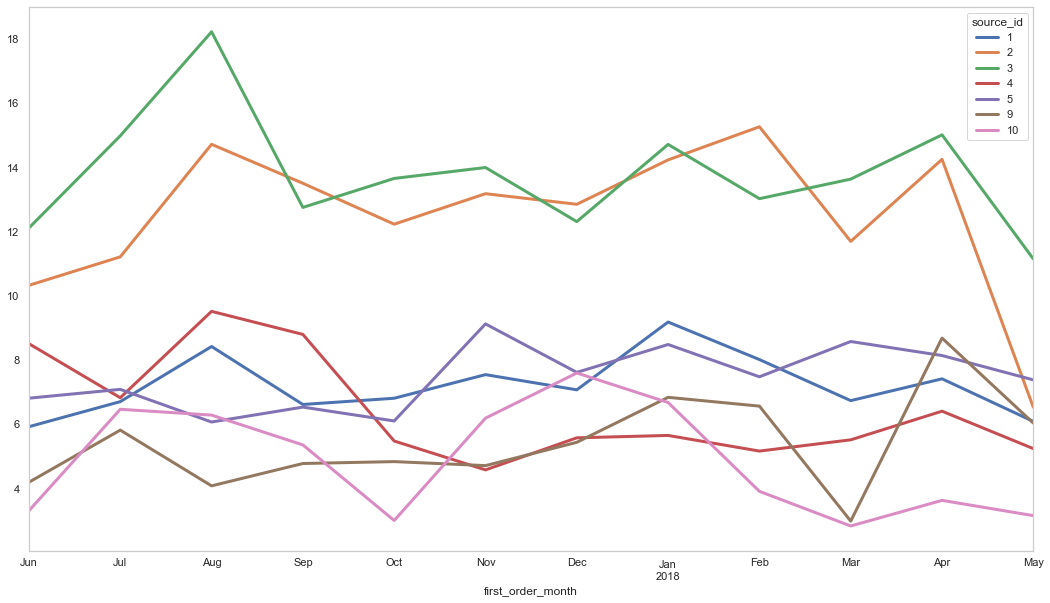

In [54]:
cac.pivot_table(index = 'first_order_month', columns = 'source_id', values = 'cac', aggfunc='mean').plot(lw=3, figsize=(18,10), grid=False)

In [55]:
cac_group=cac.groupby('source_id').agg({'cac':'mean'}).sort_values(by='cac',ascending=False).reset_index()
cac_group

,source_id,cac
0,3,13.802743
1,2,12.504068
2,5,7.451938
3,1,7.212107
4,4,6.439374
5,9,5.413892
6,10,4.867125


По графику видно, что больше всего CAC по источнику №3, примерно на том же уровне находится источник №2. Минимальная стоимость привлечения клиента п источнику №10.

#### ROMI по когортам в разрезе источников. 

In [56]:
romi=visits_orders.groupby(['source_id', 'first_order_month','order_month']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()

romi.head()

,source_id,first_order_month,order_month,revenue,uid
0,1,2017-06-01,2017-06-01,1378.70,190
1,1,2017-06-01,2017-07-01,414.98,16
2,1,2017-06-01,2017-08-01,419.43,10
3,1,2017-06-01,2017-09-01,714.24,9
4,1,2017-06-01,2017-10-01,811.20,12


In [57]:
margin_rate = 1
romi['gp']=romi['revenue']*margin_rate
romi['age'] = (
    romi['order_month'] - romi['first_order_month']
) / np.timedelta64(1, 'M')
romi['age'] = romi['age'].round().astype('int')
romi['ltv'] = romi['gp'] / romi['uid']

romi_costs=pd.merge(romi, costs, on='source_id')

romi_costs['cac']=romi_costs['costs']/romi_costs['uid']
romi_costs['romi']=romi_costs['ltv']/romi_costs['cac']

##### ROMI для 1 источника

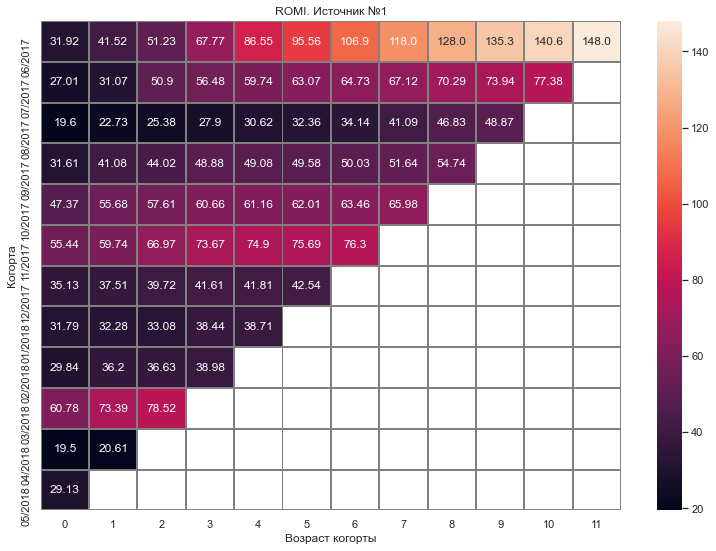

In [58]:
romi_costs1=romi_costs.query('source_id == 1')
romi_costs1=romi_costs1.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean'
).cumsum(axis=1)

romi_costs1.fillna('')
romi_costs1.index = romi_costs1.index.strftime("%m/%Y")
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9));
sns.heatmap(romi_costs1, annot=True, fmt='.4', linewidths=1, linecolor='gray');
plt.title('ROMI. Источник №1');
plt.xlabel('Возраст когорты');
plt.ylabel('Когорта');

##### ROMI для 2 источника

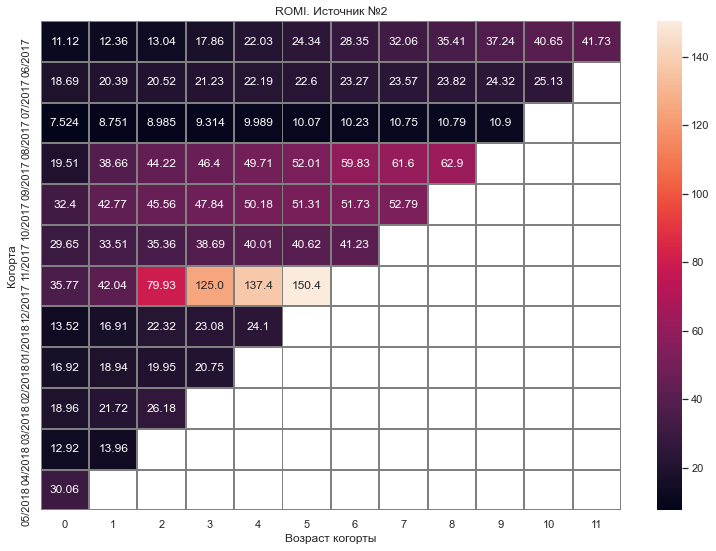

In [59]:
romi_costs2=romi_costs.query('source_id == 2')
romi_costs2

romi_costs2=romi_costs2.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean'
).cumsum(axis=1)
romi_costs2.fillna('')
romi_costs2.index = romi_costs2.index.strftime("%m/%Y")
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9));
sns.heatmap(romi_costs2, annot=True, fmt='.4', linewidths=1, linecolor='gray');
plt.title('ROMI. Источник №2');
plt.xlabel('Возраст когорты');
plt.ylabel('Когорта');

##### ROMI для 3 источника

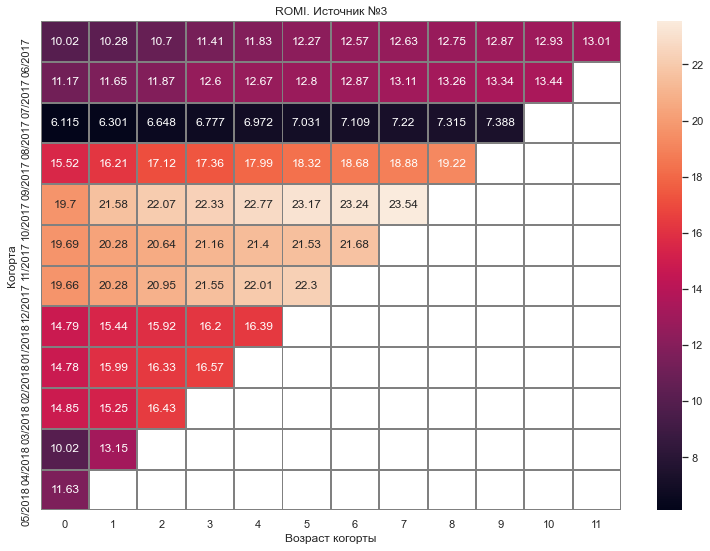

In [60]:
romi_costs3=romi_costs.query('source_id == 3')
# romi_costs3

romi_costs3=romi_costs3.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean'
).cumsum(axis=1)

romi_costs3.fillna('')
romi_costs3.index = romi_costs3.index.strftime("%m/%Y")
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9));
sns.heatmap(romi_costs3, annot=True, fmt='.4', linewidths=1, linecolor='gray');
plt.title('ROMI. Источник №3');
plt.xlabel('Возраст когорты');
plt.ylabel('Когорта');

##### ROMI для 4 источника

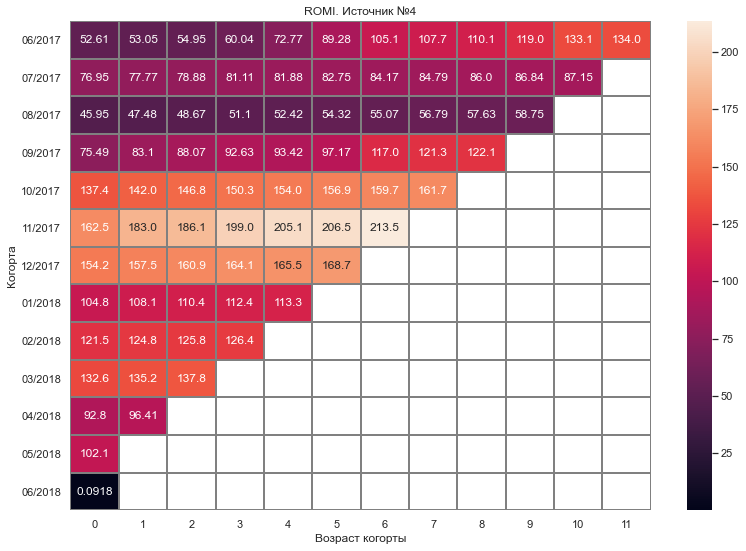

In [61]:
romi_costs4=romi_costs.query('source_id == 4')
# romi_costs4

romi_costs4=romi_costs4.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean'
).cumsum(axis=1)

romi_costs4.fillna('')
romi_costs4.index = romi_costs4.index.strftime("%m/%Y")
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9));
sns.heatmap(romi_costs4, annot=True, fmt='.4', linewidths=1, linecolor='gray');
plt.title('ROMI. Источник №4');
plt.xlabel('Возраст когорты');
plt.ylabel('Когорта');

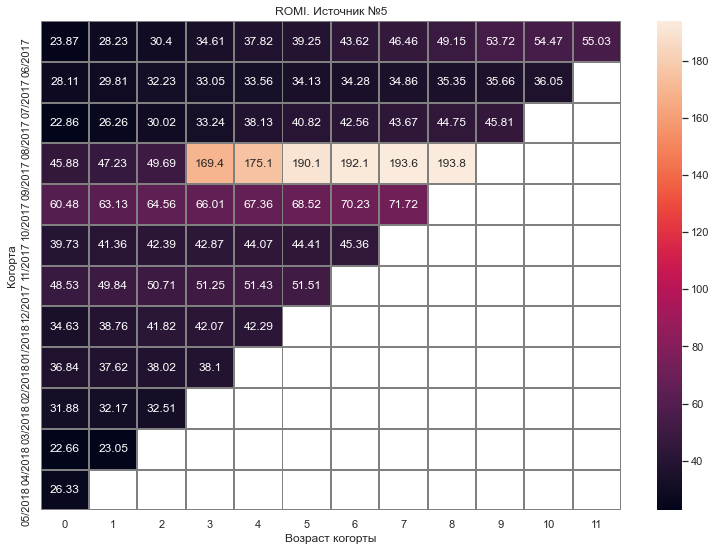

In [62]:
romi_costs5=romi_costs.query('source_id == 5')
# romi_costs5

romi_costs5=romi_costs5.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean'
).cumsum(axis=1)

romi_costs5.fillna('')
romi_costs5.index = romi_costs5.index.strftime("%m/%Y")
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9));
sns.heatmap(romi_costs5, annot=True, fmt='.4', linewidths=1, linecolor='gray');
plt.title('ROMI. Источник №5');
plt.xlabel('Возраст когорты');
plt.ylabel('Когорта');

##### ROMI для 9 источника

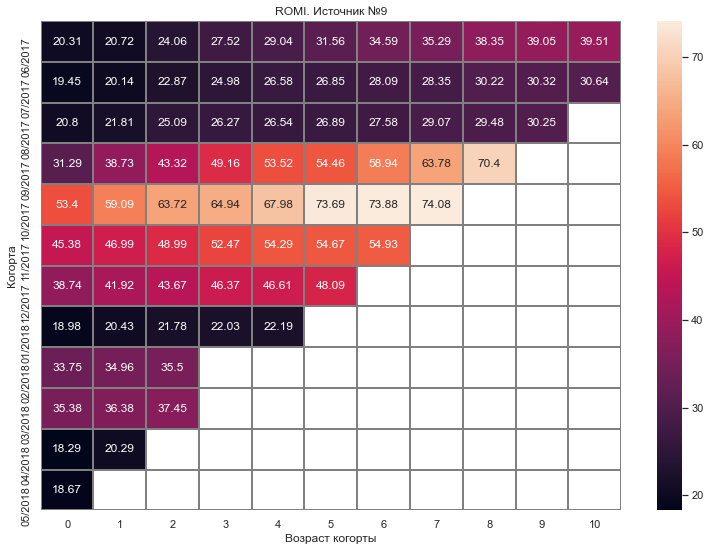

In [63]:
romi_costs9=romi_costs.query('source_id == 9')
# romi_costs3

romi_costs9=romi_costs9.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean'
).cumsum(axis=1)

romi_costs9.fillna('')
romi_costs9.index = romi_costs9.index.strftime("%m/%Y")
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9));
sns.heatmap(romi_costs9, annot=True, fmt='.4', linewidths=1, linecolor='gray');
plt.title('ROMI. Источник №9');
plt.xlabel('Возраст когорты');
plt.ylabel('Когорта');

##### ROMI для 10 источника

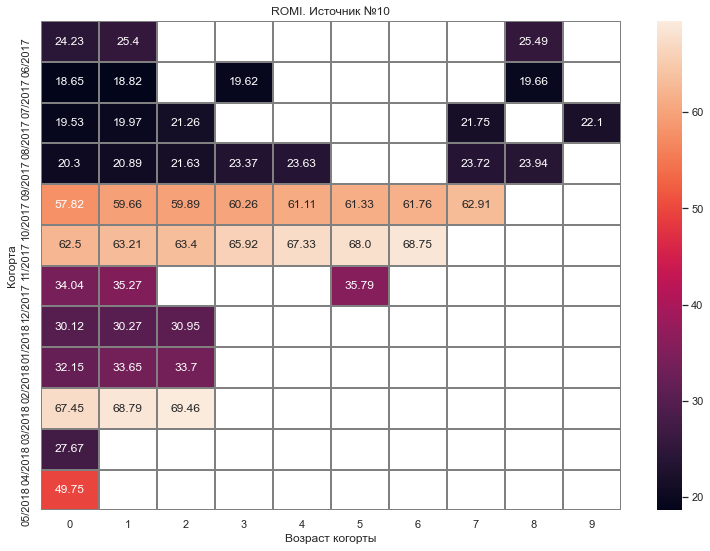

In [64]:
romi_costs10=romi_costs.query('source_id == 10')
# romi_costs10

romi_costs10=romi_costs10.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean'
).cumsum(axis=1)


romi_costs10.fillna('')
romi_costs10.index = romi_costs10.index.strftime("%m/%Y")
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9));
sns.heatmap(romi_costs10, annot=True, fmt='.4', linewidths=1, linecolor='gray');
plt.title('ROMI. Источник №10');
plt.xlabel('Возраст когорты');
plt.ylabel('Когорта');

Построили heatmap для каждого источника.

Лучше всего себя показал источник №4 на него и стоит делать упор при дальнейших рекламных компаниях. Хуже всего повел себя источник №3, возможно в будущем стоит от него отказаться. По источнику №10 не хватило исходных данных, для его правильной оценки.

## Вывод

1. Продуктовые метрики.

    Были рассчитаны средние значения и построены графики для DAU, WAU, MAU. По графикам видно, что на сайте больше всего пользователей с котбря 2017 по март 2018 года. С августа 2017 по ноябрь 2017 идет рост посетителей сайта.
    
    1. Среднее значение DAU = 907;
    2. Среднее значение WAU = 5 716; 
    3. Среднее значение MAU = 23 227.
    
    Был рассчитан retention rate. Во всех когортах виден спад активности. Лучше всего себя показывают пользователи чей визит был в июне 2017. 
   
    Также узнали продолжительность пользовательская сессии она составляет 60 секунд.
    
    
2. Метрики элекронной коммерции.

   Пользователи совершают покупку в тот же день, в который и посещают сайт. 
   
   Среднее количество покупок на одного покупателя за 6 мессяцев равно 1.26. Также количество покупок снижается от когорты к когороте. Раз идет снижение среднего количества покупок, нужно проводить какие-то дополнительные рекламные акции. 
   
   Средний чек на одного покупателя равен 5.86. Лучший показатель по среднему чеку в декабре 2017 года, в январе идет резкий спад, чтобы его не было, возможно стоит предлагать людят акции на билеты, либо при покупке билетов в январе начислять дополнительные бонусы.
   
   Построили тепловую карту по LTV. Лучше всего себя показала когорта за сентяюрь 2017 года. 
   

3. Маркетинговые метрики
    
    Посчитали затраты на каждую рекламную компанию.
    Распределение трат по источникам:

| Источник     | Расходы |
| ------------- |:--------------------:| 
| 3           | 141321.63| 
| 4           | 61073.60| 
| 5          | 51757.10| 
| 2          | 42806.04|
|1	|20833.27|
|10|5822.49|
|9	|5517.49|

   Средний CAC на одного покупателя для всего проекта равен 9.32. Больше всего денег на привлечение клиентов было вложено в августе - 10.79, январе - 9.94 и апреле - 9.79.
   Также расчитали CAC для каждого источника трафика.

| Источник     | Расходы |
| ------------- |:--------------------:|
|3|	13.802743|
|2	|12.504068|
|5	|7.451938|
|1	|7.212107|
|4	|6.439374|
|9	|5.413892|
|10	|4.867125|
   
4. ROMI
    
    Посчитали ROMI для каждого источника, и построили тепловые карты. Самые высокие показатели у источника №1, для него ROMI очень быстро растет, особенно для июньской когорты. И также высокие показатели у источника №4. По источнику №2 идет резкий рост ROMI декабрьской когорты. возможно они попали под какое-то рекламное предложение, акцию и т.д. В источник №3 лучше больше не вкладывать деньги, низкий показатель ROMI в сравнении с другими источниками. У 5 источника средние показатели, но зато идет резкий подъем в сентябрьской когоре. У 9 источника показатели также средние.
    
    Тепловая карта для источника №10 получилась с пропущенным значениями, возможно в даты когда проходила рекламная компания из этого источника, на нее никто не попал.